# Visualisation of Data streamed to MongoDB

## Imports

In [71]:
import re
import plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *


# http://tweepy.readthedocs.io/en/v3.5.0/index.html
import tweepy
from tweepy import OAuthHandler
# https://pandasguide.readthedocs.io/en/latest/
import pandas as pd
# https://numpy.readthedocs.io/en/latest/
import numpy as np
# https://api.mongodb.com/python/current/
import pymongo

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

MONGO_URL = 'mongodb://twitter-mongodb:27017/'

## MongoDB
To gain access to the mongoDB the library `pymongo` is used.

In the first step the mongoDB URL is defined.

MONGO_URL = 'mongodb://twitter-mongodb:27017/'

In [72]:
def load_from_mongo(mongo_db, mongo_db_coll, return_cursor=False, criteria=None, projection=None):
    # Optionally, use criteria and projection to limit the data that is
    # returned - http://docs.mongodb.org/manual/reference/method/db.collection.find/
    
    # Connects to the MongoDB server running on
    client = pymongo.MongoClient(MONGO_URL)
    # Reference a particular collection in the database
    db = client[mongo_db]
    # Perform a bulk insert and return the IDs
    coll = db[mongo_db_coll]
    if criteria is None:
        criteria = {}
    if projection is None:
        cursor = coll.find(criteria)
    else:
        cursor = coll.find(criteria, projection)
    
    # Returning a cursor is recommended for large amounts of data
    if return_cursor:
        return cursor
    else:
        return [ item for item in cursor ]

## Get some tweets to work with

In [73]:
#load tweets from a mongo (trump db)
tweets = load_from_mongo('trump', 'tweets')
for t in tweets[:5]:
    print(t['text'])

The single greatest Witch Hunt in American history continues. There was no collusion, everybody including the Dems… https://t.co/j7rc1QKCLw
The fact that Sneaky Dianne Feinstein, who has on numerous occasions stated that collusion between Trump/Russia has… https://t.co/o5FAEfhS7N
It just shows everyone how broken and unfair our Court System is when the opposing side in a case (such as DACA) al… https://t.co/sXFgY5c11s
.@ICEgov HSI agents and ERO officers, on behalf of an entire Nation, THANK YOU for what you are doing 24/7/365 to k… https://t.co/yN90uqG6z8
Thank you @GOPLeader Kevin McCarthy! Couldn’t agree w/you more. TOGETHER, we are #MAGA🇺🇸 https://t.co/QaxtqpyXTR


## Creating a DataFrame with Pandas

In [74]:
# Create a pandas DataFrame out of the tweets
data = pd.DataFrame(data=[t['text'] for t in tweets], columns=['Tweets'])

# Diplay the first 5 elements of the DataFrame
display(data.head(5))

,Tweets
0,The single greatest Witch Hunt in American his...
1,"The fact that Sneaky Dianne Feinstein, who has..."
2,It just shows everyone how broken and unfair o...
3,".@ICEgov HSI agents and ERO officers, on behal..."
4,Thank you @GOPLeader Kevin McCarthy! Couldn’t ...


## Extend our DataFrame

In [150]:
# We add relevant data for Numpy Array:
data['len']  = np.array([len(t['text']) for t in tweets])
data['ID']   = np.array([t['id'] for t in tweets])
data['Date'] = np.array([t['created_at'] for t in tweets])
data['Source'] = np.array([t['source'] for t in tweets])
data['Likes']  = np.array([t['favorite_count'] for t in tweets])
data['RTs']    = np.array([t['retweet_count'] for t in tweets])

display(data.head(10))

,Tweets,len,ID,Date,Source,Likes,RTs
0,The single greatest Witch Hunt in American his...,139,951109942685126656,Wed Jan 10 15:14:15 +0000 2018,"<a href=""http://twitter.com/download/iphone"" r...",32416,8281
1,"The fact that Sneaky Dianne Feinstein, who has...",140,951106475254059008,Wed Jan 10 15:00:29 +0000 2018,"<a href=""http://twitter.com/download/iphone"" r...",27652,7597
2,It just shows everyone how broken and unfair o...,140,951094078661414912,Wed Jan 10 14:11:13 +0000 2018,"<a href=""http://twitter.com/download/iphone"" r...",41493,10989
3,".@ICEgov HSI agents and ERO officers, on behal...",140,950946293077209088,Wed Jan 10 04:23:58 +0000 2018,"<a href=""http://twitter.com/download/iphone"" r...",41835,9688
4,Thank you @GOPLeader Kevin McCarthy! Couldn’t ...,112,950937350003183618,Wed Jan 10 03:48:26 +0000 2018,"<a href=""http://twitter.com/download/iphone"" r...",34804,8190
5,"As I made very clear today, our country needs ...",135,950884128379035650,Wed Jan 10 00:16:57 +0000 2018,"<a href=""http://twitter.com/download/iphone"" r...",98287,20114
6,"RT @Scavino45: “Utilities cutting rates, cite ...",99,950879772644659200,Tue Jan 09 23:59:38 +0000 2018,"<a href=""http://twitter.com/download/iphone"" r...",0,8820
7,"Today, it was my great honor to sign a new Exe...",139,950866561153331202,Tue Jan 09 23:07:09 +0000 2018,"<a href=""http://twitter.com/download/iphone"" r...",62548,15026
8,Thanks to all of the Republican and Democratic...,140,950862709599465472,Tue Jan 09 22:51:50 +0000 2018,"<a href=""http://twitter.com/download/iphone"" r...",48641,10297
9,"It was my great honor to sign H.R. 267, the “M...",140,950823813868122112,Tue Jan 09 20:17:17 +0000 2018,"<a href=""http://twitter.com/download/iphone"" r...",60690,14480


## Get average length of Tweets

In [151]:
# We extract the mean of lenghts:
mean = np.mean(data['len'])

print("The lenght's average in tweets: {}".format(mean))

The lenght's average in tweets: 123.38736776602364


## Get Tweets with the Most Likes and Retweets

In [155]:
# We extract the tweet with more FAVs and more RTs:

fav_max = np.max(data['Likes'])
rt_max  = np.max(data['RTs'])

fav = data[data.Likes == fav_max].index[0]
rt  = data[data.RTs == rt_max].index[0]

# Max FAVs:
print("The tweet with more likes is: \n{}".format(data['Tweets'][fav]))
print("Number of likes: {}".format(fav_max))
print("{} characters.\n".format(data['len'][fav]))

# Max RTs:
print("The tweet with more retweets is: \n{}".format(data['Tweets'][rt]))
print("Number of retweets: {}".format(rt_max))
print("{} characters.\n".format(data['len'][rt]))

The tweet with more likes is: 
Why would Kim Jong-un insult me by calling me "old," when I would NEVER call him "short and fat?" Oh well, I try so… https://t.co/PmsWNkH4r4
Number of likes: 617687
140 characters.

The tweet with more retweets is: 
#FraudNewsCNN #FNN https://t.co/WYUnHjjUjg
Number of retweets: 361899
42 characters.



## Get Tweets with the Least Likes and Retweets

In [156]:
# We extract the tweet with more FAVs and more RTs:

fav_min = np.min(data['Likes'])
rt_min  = np.min(data['RTs'])

data_fav_min = data[data.Likes == fav_min].index[0]
data_rt_min  = data[data.RTs == rt_min].index[0]

# Max FAVs:
print("The tweet with the minimum likes is: \n{}".format(data['Tweets'][data_fav_min]))
print("Number of likes: {}".format(fav_min))
print("{} characters.\n".format(data['len'][data_fav_min]))

# Max RTs:
print("The tweet with minimum retweets is: \n{}".format(data['Tweets'][data_rt_min]))
print("Number of retweets: {}".format(rt_min))
print("{} characters.\n".format(data['len'][data_rt_min]))

The tweet with the minimum likes is: 
RT @Scavino45: “Utilities cutting rates, cite benefits of Trump tax reform” https://t.co/u19JMs4Bsr
Number of likes: 0
99 characters.

The tweet with minimum retweets is: 
@IMPDnews @POTUS THANK YOU to the amazing Indianapolis Metropolitan Police Department and all law enforcement offic… https://t.co/eulFI3CGcL
Number of retweets: 1518
140 characters.



## We create time series for data

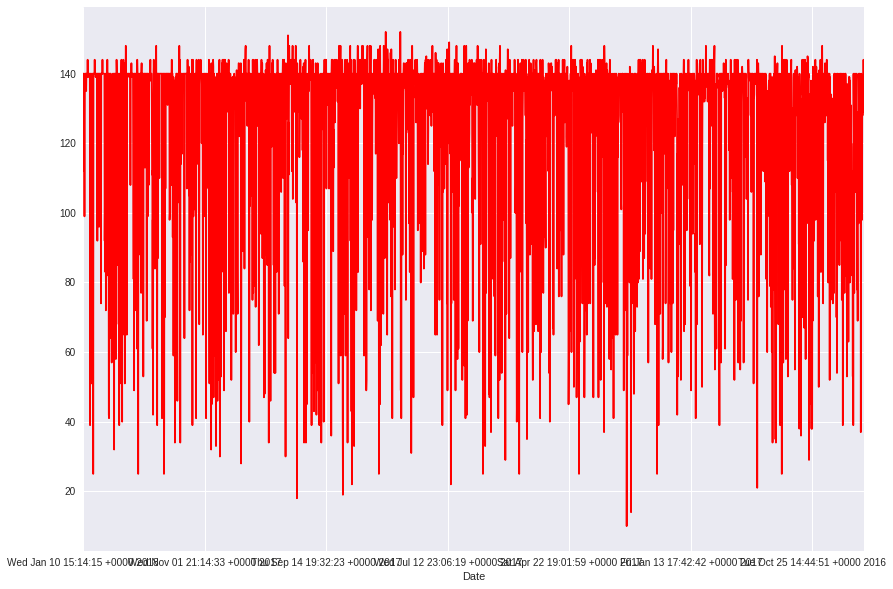

In [189]:
# One-dimensional ndarray with axis labels (including time series)

tlen = pd.Series(data=data['len'].values, index=data['Date'])

# Lenghts along time:
tlen.plot(figsize=(14,10), color='r', label='Length of Tweets');

## Limit the Data used (Length of Tweets)

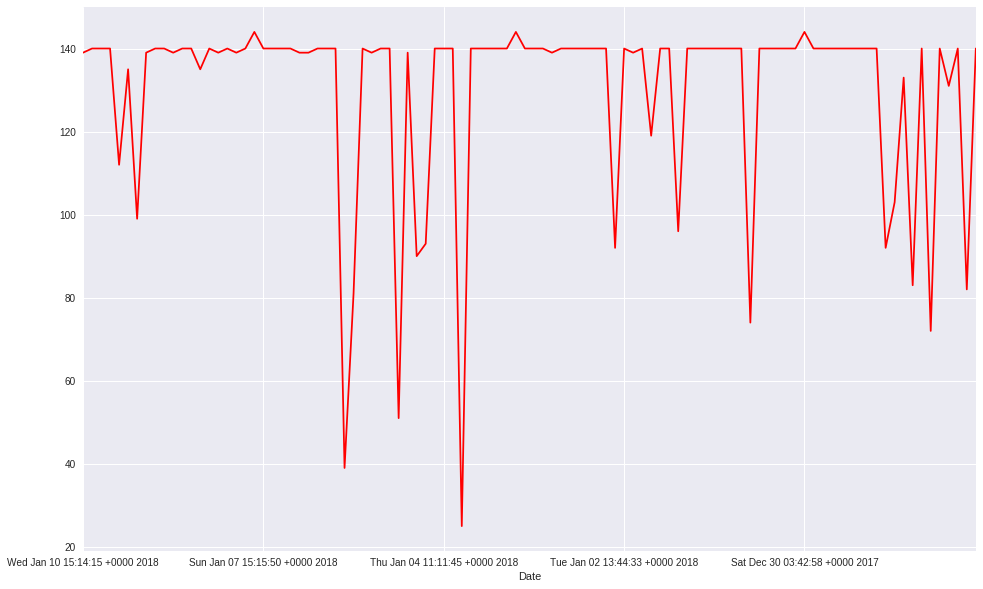

In [190]:
#Limit Data to first 100 because it would be overwhelming
data_oneHundred = data.head(100)

tlen = pd.Series(data=data_oneHundred['len'].values, index=data_oneHundred['Date'])

# Lenghts along time:
tlen.plot(figsize=(16,10), color='r', label='Length of Tweets');

## Likes and Retweets

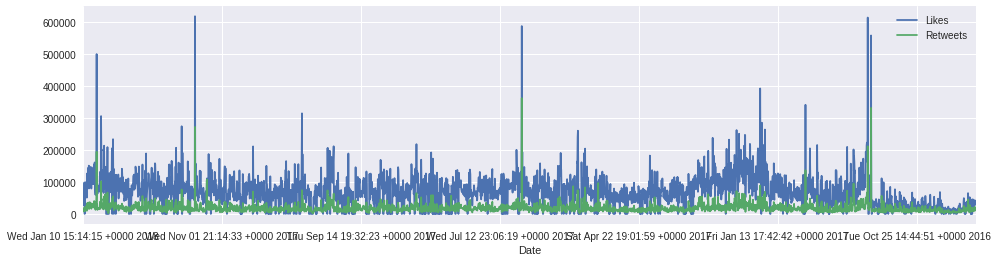

In [192]:
tfav = pd.Series(data=data['Likes'].values, index=data['Date'])
tret = pd.Series(data=data['RTs'].values, index=data['Date'])

# Likes vs retweets visualization:
tfav.plot(figsize=(16,4), label="Likes", legend=True)
tret.plot(figsize=(16,4), label="Retweets", legend=True);

## Limit the data used (Likes and retweets)

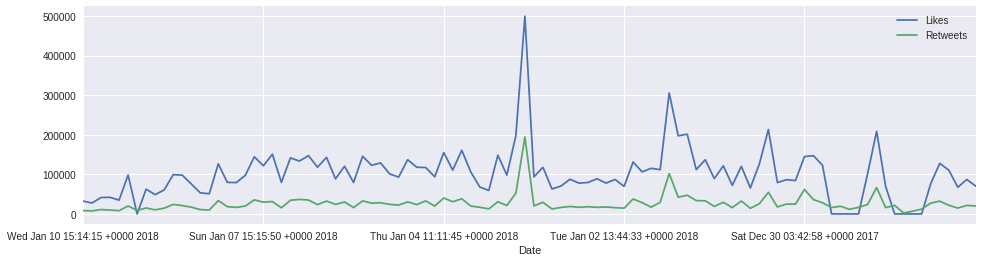

In [193]:
tfav = pd.Series(data=data_oneHundred['Likes'].values, index=data_oneHundred['Date'])
tret = pd.Series(data=data_oneHundred['RTs'].values, index=data_oneHundred['Date'])

# Likes vs retweets visualization:
tfav.plot(figsize=(16,4), label="Likes", legend=True)
tret.plot(figsize=(16,4), label="Retweets", legend=True);

### Figure out (LIVE!) which tweet skyrocket on 3rd of January (Dates may vary)

In [215]:
likes_max = np.max(data_oneHundred['Likes'])
likes_data = data_oneHundred[data_oneHundred.Likes == likes_max].index[0]

print("The tweet with the maximum likes is: \n{}".format(data_oneHundred['Tweets'][likes_data]))
print("Number of likes: {}".format(likes_max))
print("{} characters.\n".format(data['len'][likes_data]))

The tweet with the maximum likes is: 
North Korean Leader Kim Jong Un just stated that the “Nuclear Button is on his desk at all times.” Will someone fro… https://t.co/EvTgZxiji0
Number of likes: 499435
140 characters.



## Go through all sources and list them (only unique Entry's)

In [245]:
import re

# We obtain all possible sources:
sources = []
for source in data['Source']:
    source_text = ''.join(re.findall('.*>(.*)<.*',source))
    if source_text not in sources:
        sources.append(source_text)

# We print sources list:
print("Creation of content sources:")
for source in sources:
    print("* {}".format(source))

Creation of content sources:
* Twitter for iPhone
* Twitter Web Client
* Media Studio
* Twitter for iPad
* Twitter Ads
* Twitter for Android
* Periscope


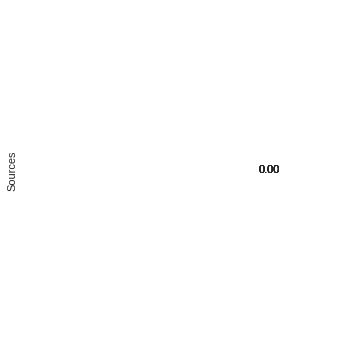

In [246]:
# We create a numpy vector mapped to labels:
percent = np.zeros(len(sources))

'''for source in data['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass'''

percent /= 100

# Pie chart:
pie_chart = pd.Series(percent, index=sources, name='Sources')
pie_chart.plot.pie(fontsize=11, autopct='%.2f', figsize=(6, 6));